<a href="https://colab.research.google.com/github/owengenge/cap-comp215/blob/main/Project_2_Owen_Genge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    Name: Owen Genge

    Date: April 8, 2023


# **Forest Fire Model Moisture Layer** 

  In this project, I have developed a new class called ForestFireMoisture that inherits from the original ForestFire class, but with an added moisture layer component. By incorporating moisture into the model, I am able to analyze and simulate new patterns that involve the moisture levels of trees, enabling a better understanding of forest fire dynamics.

## **Setup**

Inlcudes import libraries, the plot_2D_array function, the Animation2D class and the original ForestFire class.

In [2]:
%matplotlib inline

import time

import pprint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d
import random

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [3]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [4]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [5]:
class ForestFire:
  """ 2D Cellular Automaton that simulates a fire-dominated landscape """

  # Define names for the 3 possible cell states
  EMPTY = 0
  OCCUPIED = 1
  FIRE = 5

  # Define a colour map that maps each cell state to an intuitive colour.
  cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
  cmap[EMPTY] = (1, 0.5, 0)  # brown
  cmap[OCCUPIED] = (0, 1, 0)  # green
  cmap[FIRE] = (1, 0, 0)  # red
  forest_colour_map = matplotlib.colors.ListedColormap(cmap)

  # TODO: define a sensible correlation kernel
  kernel = np.array([[0, 1, 0],
                      [1, 0, 1],
                      [0, 1, 0]])


  def __init__(self, n, p=0.01, f=0.001, q=0.5):
      """Initializes the model.

      n: number of rows
      p: probability an empty cells becomes "forested" (occupied)
      f: probability of spontaneous file (e.g., 1/fire ignition interval)
      q: initial forest density (probability cell is "forested" in initial state)
      """
      self.p = p
      self.f = f
      self.n = n
      # initialize landscape with approx. q proportion of cells OCCUPIED
      self.array = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])
      

  def step(self):
      """Executes one time step, applying the CA rules to regenerate and burn forest."""
      # TODO: define the rules for the CA.  This is a significant challenge b/c there are 4 rules and they must act independently!

      transitions = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')

      occupied = (self.array == 1)
      neighbours_on_fire = (transitions >= 5)
      on_fire = (self.array == 5)
      empty = (self.array == 0)

      #occupied cell catches on fire with f
      self.array[occupied] = np.random.choice(
          [self.FIRE, self.OCCUPIED],
          self.array[occupied].shape,
          p = [self.f, 1-self.f]
          ) 
      
      #occupied cell catches on fire
      self.array[neighbours_on_fire & occupied] = self.FIRE 

      #on fire tree turns empty
      self.array[on_fire] = 0

      #empty cell grows tree with p
      self.array[empty] = np.random.choice( 
          [self.OCCUPIED, self.EMPTY],
          self.array[empty].shape,
          p = [self.p, 1-self.p]
          ) 
      return self

  def num_occupied(self):
      """ return the number of cells occupied by forest """
      return  sum(sum(self.array==1)) # TODO: count the number of forested cells.


  def pct_occupied(self):
      """ return the proportion of cells occupied by forest """
      return self.num_occupied() / self.array.size


  def draw(self, axes=None, step=''):
      """Draws the CA cells using the forest colour map so values are coloured intuitively."""
      axes = axes or plt.gca()
      title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
      plot_2D_array(self.array, axes=axes, title=title,
                    cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))
      


## **ForestFireMoisture Class** 
Inherits original ForestFire class

**Added Features:** 

- **Initializes a moisture matrix** that determines the moisture level of a cell by changing its probability to catch on fire. 
  - Drier cells have values closer to 1
  - Moister cells have values closer to 0

- **Changes to the step method** that is tailored to account for the moisture levels of each cell: 
  - Occupied cells with neighbours on fire catch on fire depending on moisture level
  - Occupied cells randomly catch on fire depending on moisture level
  - Empty cells grow trees depending on the moisture level of the cell (moister cells are more likely to grow trees)

- **draw_moisture_map** method displays the moisture levels of the moisture matrix using a yellow (dry) to dark green (moist) gradient   
  

array([[1.     , 0.98125, 0.9625 , 0.94375, 0.925  , 0.90625, 0.8875 ],
       [0.86875, 0.85   , 0.83125, 0.8125 , 0.79375, 0.775  , 0.75625],
       [0.7375 , 0.71875, 0.7    , 0.68125, 0.6625 , 0.64375, 0.625  ],
       [0.60625, 0.5875 , 0.56875, 0.55   , 0.53125, 0.5125 , 0.49375],
       [0.475  , 0.45625, 0.4375 , 0.41875, 0.4    , 0.38125, 0.3625 ],
       [0.34375, 0.325  , 0.30625, 0.2875 , 0.26875, 0.25   , 0.23125],
       [0.2125 , 0.19375, 0.175  , 0.15625, 0.1375 , 0.11875, 0.1    ]])

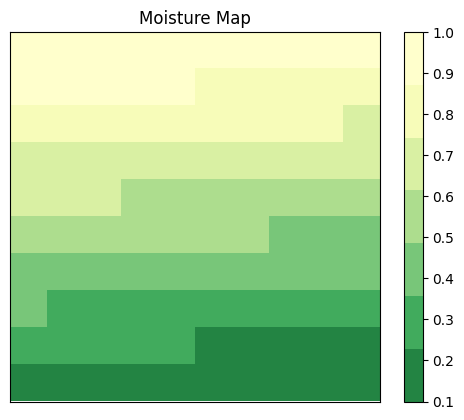

In [16]:
class ForestFireMoisture(ForestFire):

    # define colour map for moisture map
    color_list = ['#ffffcc', '#f7fcb9', '#d9f0a3', '#addd8e', '#78c679', '#41ab5d', '#238443']
    color_list.reverse()
    moist_cmap = matplotlib.colors.ListedColormap(color_list)

    def __init__(self, n, p=0.01, f=0.001, q=0.5):
        super().__init__(n, p, f, q)
        # moisture matrix. Descending probability to catch fire from top left to bottom right of the matrix.
        # highest probability to catch fire are the dryest cells and lowest are the moistest 
        self.moisture = (np.linspace(1, 0.1, n*n).reshape((n, n))) 

    def step(self):
      """Executes one time step, applying the CA rules to regenerate and burn forest."""

      transitions = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')

      occupied = (self.array == 1)
      neighbours_on_fire = (transitions >= 5)
      on_fire = (self.array == 5)
      empty = (self.array == 0)

      #on fire tree turns empty
      self.array[on_fire] = 0

      #occupied cell catches on fire if neighbouring cell is on fire (depending on moisture level)
      can_catch_fire = np.random.random(self.array.shape) < self.moisture
      self.array[can_catch_fire & neighbours_on_fire & occupied] = self.FIRE 

      #occupied randomly cell catches on fire  depending on moisture 
      can_catch_fire_f = np.random.random(self.array.shape) < (self.moisture * self.f)
      self.array[occupied & can_catch_fire_f] = self.FIRE

      #empty cell grows tree depending on how moist the cell is
      can_grow = np.random.random(self.array.shape) < ((np.linspace(0.1, 1, self.n*self.n).reshape((self.n, self.n))) * self.p)
      self.array[empty & can_grow] = self.OCCUPIED
      
      return self
    
    def draw_moisture_map(self, axes=None):
      """
      Displays a moisture map using a color gradient from yellow (driest cells) to dark green (moistest cells).
      """
      # display the moisture map using the specified color gradient
      fig, ax = plt.subplots()
      im = ax.imshow(self.moisture, cmap=self.moist_cmap)
      fig.colorbar(im)
      ax.set_title("Moisture Map")
      ax.set_xticks([])
      ax.set_yticks([])
      plt.show()

display(ForestFireMoisture(7).moisture)
ForestFireMoisture(10).draw_moisture_map()

### Original and Randomized Moisture Maps

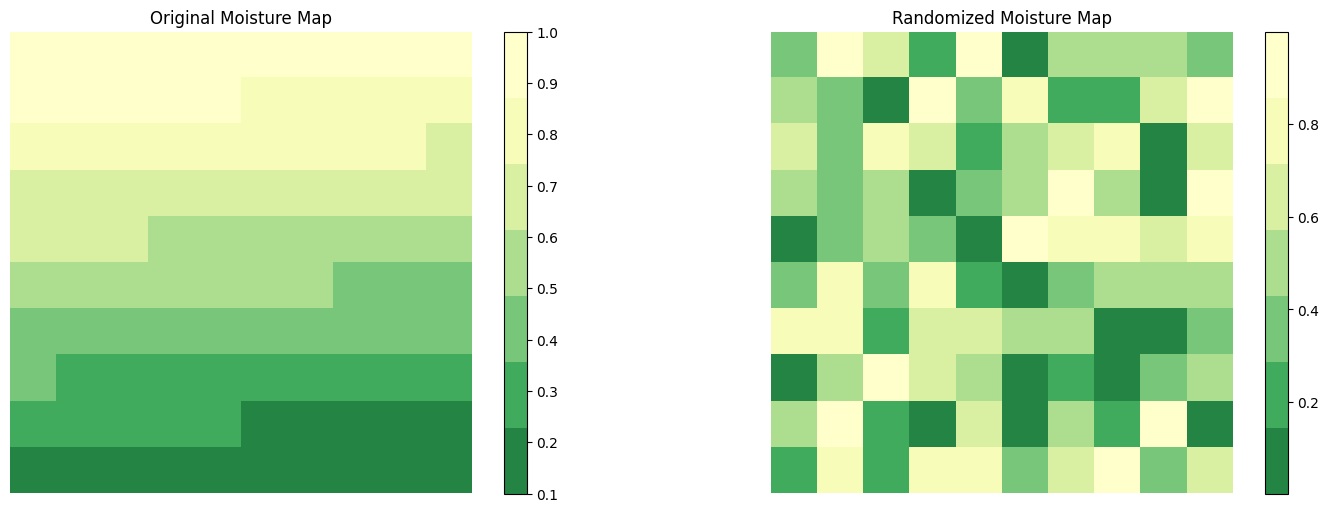

In [7]:
forest = ForestFireMoisture(10)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
im1 = axs[0].imshow(forest.moisture, cmap=forest.moist_cmap)
axs[0].set_title("Original Moisture Map")
fig.colorbar(im1, ax=axs[0])
axs[0].set_axis_off()

moisture_map = np.random.random(forest.array.shape)
im2 = axs[1].imshow(moisture_map, cmap=forest.moist_cmap)
axs[1].set_title("Randomized Moisture Map")
fig.colorbar(im2, ax=axs[1])
axs[1].set_axis_off()

plt.show()

### Fire Spread With Original Moisture Layer Animation 

Using the original moisture map shown above we can see it's effects on the moisture layer using an animation.

- On the drier side trees...
  - are more likely to catch on fire
  - grow less frequently 

- On the moister side trees...
  - are less likely to catch on fire
  - grow more frequently 



In [8]:
m = ForestFireMoisture(10, q=1, f=0.009, p=0.09)

a= Animation2D(m, frames=50, figsize=(6, 6))

a.show()

## **Simulations**


### Steady state simulation

- Displays the percent of occupied cells over a given number of steps

- Finds the average percent of occupied cells when the model is at a steady state 

- Compares the ForestFire and ForestFireMoisture

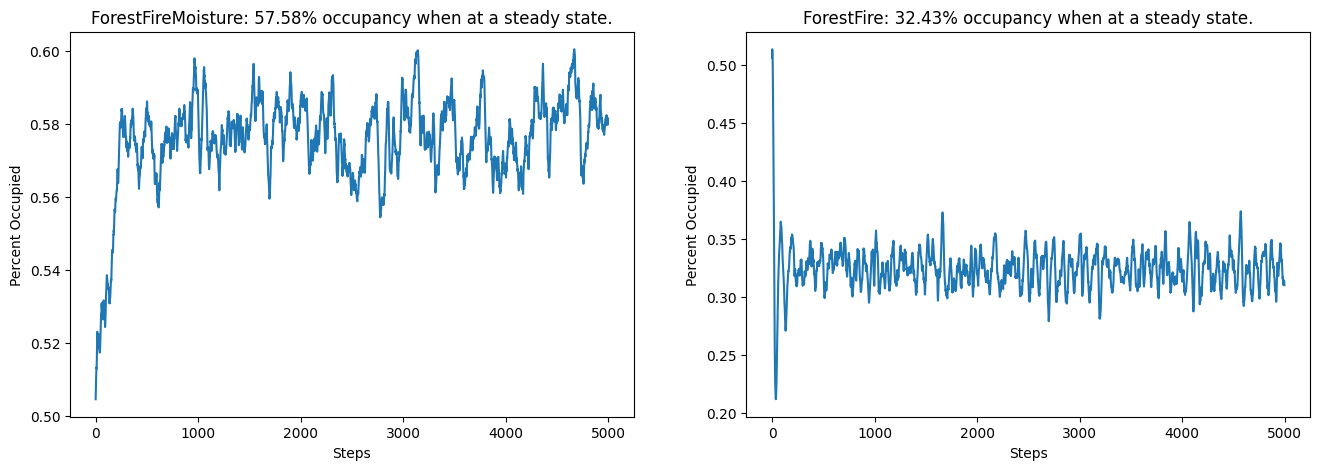

In [22]:
def simulate(m, steps):
  """ finds the average percent of occupied cells when the model is at a steady state """
  per_occupied = [m.step().pct_occupied() for i in range(steps)]
  steps_list = [i for i in range(steps)]
  return [steps_list, per_occupied]

m_moist = ForestFireMoisture(100)
#m_moist.moisture = np.random.random(m_moist.array.shape) # random moisture matrix 
sim_data_moist = simulate(m=m_moist, steps=5000)

m = ForestFire(100)
#m.moisture = np.random.random(m.array.shape) # random moisture matrix 
sim_data = simulate(m=m, steps=5000)

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# plot for sim_data_moist
axs[0].plot(sim_data_moist[0], sim_data_moist[1])
axs[0].set_title(f'ForestFireMoisture: {round(np.average(sim_data_moist[1])*100,2)}% occupancy when at a steady state.')
axs[0].set_xlabel('Steps') 
axs[0].set_ylabel('Percent Occupied')

# plot for sim_data
axs[1].plot(sim_data[0], sim_data[1])
axs[1].set_title(f'ForestFire: {round(np.average(sim_data[1])*100,2)}% occupancy when at a steady state.')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Percent Occupied')

plt.show()

### Wet and Dry Season Simulations

- Displays the percent of occupied cells over a given number of steps

- Simulates the seasons by incrementally increasing/decreasing the moisture matrix

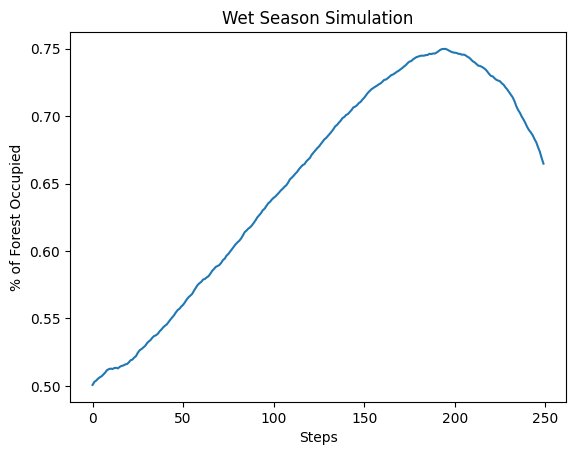

In [10]:
def sim_wet_season(m, steps):
  """ Simulates a wet season by decreasing and increasing the moisture map """

  initial_moisture = m.moisture.copy() # Store the initial moisture map
  
  per_occupied = []
  steps_list = []
  
  for i in range(steps):
    
    if i < (steps // 2): # Increase moisture levels (by reducing the moisture probability map)
      m.moisture -= (initial_moisture / (steps // 2))
      
    if i >= (steps // 2): # Decrease moisture levels (by increasing the moisture probability map)
      m.moisture += (initial_moisture / (steps // 2))
      
    m.step()
    per_occupied.append(m.pct_occupied())
    steps_list.append(i)

  return [steps_list, per_occupied]

sim_wet_data = sim_wet_season(m=ForestFireMoisture(100, q=0.5, p=0.01, f=0.001), steps=250)

plt.title('Wet Season Simulation')
plt.xlabel('Steps')
plt.ylabel('% of Forest Occupied')
plt.plot(sim_wet_data[0], sim_wet_data[1])


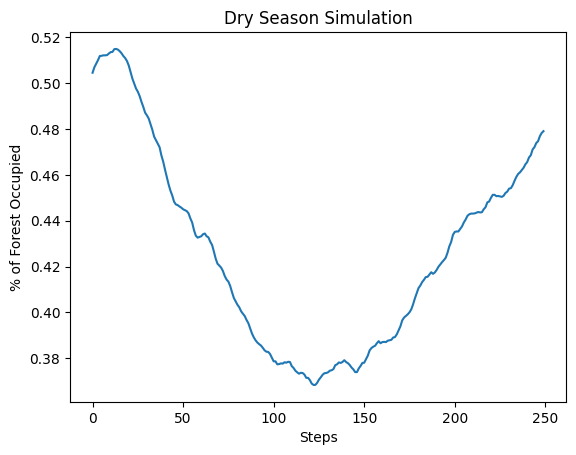

In [11]:
def sim_dry_season(m, steps):
  """ Simulates a dry season by decreasing and increasing the moisture map """

  initial_moisture = m.moisture.copy() # Store the initial moisture map
  
  per_occupied = []
  steps_list = []
  
  for i in range(steps):
    
    if i < (steps // 2): # Decrease moisture levels (by increasing the moisture probability map)
      m.moisture += (initial_moisture / (steps // 2))
      
    if i >= (steps // 2): # Increase moisture levels (by reducing the moisture probability map)
      m.moisture -= (initial_moisture / (steps // 2))
      
    m.step()
    per_occupied.append(m.pct_occupied())
    steps_list.append(i)

  return [steps_list, per_occupied]

sim_dry_data = sim_dry_season(m=ForestFireMoisture(100, q=0.5, p=0.01, f=0.001), steps=250)

plt.title('Dry Season Simulation')
plt.xlabel('Steps')
plt.ylabel('% of Forest Occupied')
plt.plot(sim_dry_data[0], sim_dry_data[1])


### Annual Simulation

- Displays the percent of occupied cells over a given number of steps

- Simulates a year of forest fires by combining the wet and dry season simulations 

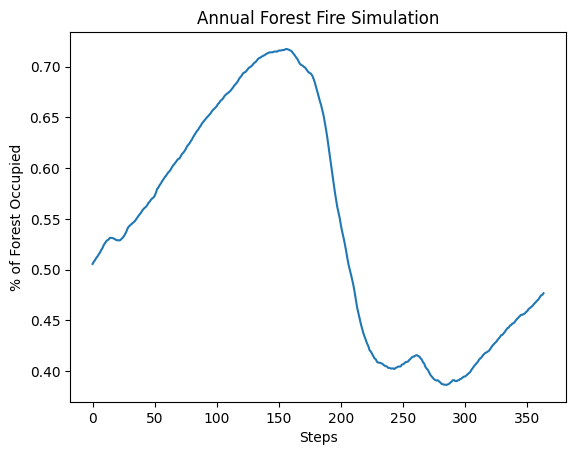

In [12]:
def sim_annual(m, steps):
  """ Simulates a year of forest fires by combining the wet and dry season simulations """
  wet_data = sim_wet_season(m, steps=steps//2)
  dry_data = sim_dry_season(m, steps=steps//2)
  
  wet_data[0] += dry_data[0]
  wet_data[1] += dry_data[1]

  per_occupied = wet_data[1]
  steps_list = [i for i in range(len(wet_data[0]))]

  return [steps_list, per_occupied]
  
sim_annual_data = sim_annual(m=ForestFireMoisture(100, q=0.5, p=0.01, f=0.001), steps=365)

plt.title('Annual Forest Fire Simulation')
plt.xlabel('Steps')
plt.ylabel('% of Forest Occupied')
plt.plot(sim_annual_data[0], sim_annual_data[1])

 
